# 03_TPF_Statistics

In diesem Jupyter Notebook werden Statistiken und Visualisierungen aus Daten der Punktwolken und der Metashape Reports generiert. 
Die Daten basieren auf Bilder der DJI Mini 3 Pro von den folgenden Aufnahmetagen:
11.03.2025 und
19.03.2025

### Import der Libraries

In [3]:
import pandas as pd
import glob
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import numpy as np
import laspy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
import traceback

### Definition der Grundlagedaten

In [6]:
# CSV-Verzeichnis
csv_dir = "C:\\_Data\\BTh11\\BTh11_Trieblaengenwachstum\\03_TPF_Statistics\\30_BaseData\\CSV"
print("Daten in CSV-Verzeichnis:", os.listdir(csv_dir))

# PointCloud-Verzeichnis auf HDD
# pc_hdd_dir = "F:\\530_PointClouds_TPF"
# print("Daten in PointCloud-Verzeichnis (HDD):", os.listdir(pc_hdd_dir))

# PointCloud-Verzeichnis 
pc_dir = "C:\\_Data\\BTh11\\BTh11_Trieblaengenwachstum\\03_TPF_Statistics\\30_BaseData\\PointCloud"
print("Daten in PointCloud-Verzeichnis:", os.listdir(pc_dir))


Daten in CSV-Verzeichnis: ['MetashapeReportData_20250311_DJIMini3Pro_Kirsche.csv', 'MetashapeReportData_20250319_DJIMini3Pro_Kirsche.csv', 'MetashapeReportData_20250326_DJIMini3Pro_Kirsche.csv', 'old']
Daten in PointCloud-Verzeichnis: ['20250311_DJIMini3Pro_Kirsche_TiePointFiltering_100_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_20_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_40_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_60_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_80_clipped.las']


## 1. Analyse Report Data aus Metashape
Für die folgenden Unterkapitel werden Metadaten aus Metashape verwendet. Diese Metadaten bestehen aus Berechnungsparametern oder berechneten Anzahl Punkten oder Filtering Tresholds. Im Kapitel 1.2 und Kapitel 1.3 werden vorallem die Root Mean Square Error-Werte (RSME-Werte) für die Visualisierungen verwendet.

### 1.1 Import der CSV-Daten
Prüfung des CSV-Imports

In [7]:
# Laden aller CSV-Dateien MetashapeReportData_<ID>.csv finden
csv_files = glob.glob(os.path.join(csv_dir, "MetashapeReportData_*.csv"))

# Alle CSVs einlesen und in einer Liste speichern
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Alle DataFrames zusammenfügen
combined_df = pd.concat(df_list, ignore_index=True)

# Vorschau
display(HTML(combined_df.head(20).to_html(max_cols=200, notebook=True)))

,Aufnahme_ID,TPF,Anzahl_Ringe,Nadir,Anzahl_Bilder,Format,Windboehen,ImageAlignement_Accuracy,Key_Point_Limit,Tie_Point_Limit,Excl_Stationary_Tie_Pts,Guided_Img_Matching,Adaptive_Model_Fitting,Start_Points,Automatic_Filtering,Manual_Filtering,Reprojection_Error,Reconstruction_Uncertainty,Image_Count,Projection_Accuracy,Automatic_Detection,GCP_Accuracy_m,XY_Error_mm,Z_Error_mm,Total_Error_mm,Error_pix,Metashape_Report,Source_Data,PointCloud_Quality,Depth_Filtering,Point_Colors,Point_Confidence,Points_Total,Points_Tree
0,20250311_DJIMini3Pro_Kirsche,100%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,319000,NaN,NaN,NaN,NaN,True,0.01,9.42,3.69,10.12,3.89,True,DM,U-High,Mild,True,True,378.0,NaN
1,20250311_DJIMini3Pro_Kirsche,90%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,287000,NaN,52.0,NaN,24.0,True,0.01,10.41,3.72,11.06,3.52,True,DM,U-High,Mild,True,True,377.0,NaN
2,20250311_DJIMini3Pro_Kirsche,80%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,256000,NaN,37.0,NaN,10.0,True,0.01,9.33,3.55,9.98,4.05,True,DM,U-High,Mild,True,True,375.0,NaN
3,20250311_DJIMini3Pro_Kirsche,70%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,223000,NaN,29.0,NaN,7.0,True,0.01,10.95,3.55,11.51,3.45,True,DM,U-High,Mild,True,True,374.0,NaN
4,20250311_DJIMini3Pro_Kirsche,60%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,194000,NaN,24.0,NaN,8.0,True,0.01,9.69,3.36,10.25,4.07,True,DM,U-High,Mild,True,True,373.0,NaN
5,20250311_DJIMini3Pro_Kirsche,40%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,128000,NaN,18.0,NaN,7.0,True,0.01,9.65,3.46,10.25,4.11,True,DM,U-High,Mild,True,True,364.0,NaN
6,20250311_DJIMini3Pro_Kirsche,20%,7.0,True,223.0,H,False,Highest,60000,0,True,False,True,417000,319000,64000,NaN,12.0,NaN,6.0,True,0.01,9.92,3.70,10.58,4.12,True,DM,U-High,Mild,True,True,347.0,NaN
7,20250319_DJIMini3Pro_Kirsche,100%,7.0,True,500.0,H,False,Highest,60000,0,True,False,True,1188000,867000,867000,NaN,NaN,NaN,NaN,True,0.01,7.54,4.56,8.81,2.49,True,DM,U-High,Mild,True,True,452.0,NaN
8,20250319_DJIMini3Pro_Kirsche,90%,7.0,True,500.0,H,False,Highest,60000,0,True,False,True,1188000,867000,781000,NaN,NaN,NaN,23.0,True,0.01,7.35,4.71,8.73,2.51,True,DM,U-High,Mild,True,True,453.0,NaN
9,20250319_DJIMini3Pro_Kirsche,80%,7.0,True,500.0,H,False,Highest,60000,0,True,False,True,1188000,867000,694000,NaN,NaN,NaN,27.0,True,0.01,7.30,4.64,8.65,2.50,True,DM,U-High,Mild,True,True,457.0,NaN


### 1.2 Vergleich Root Mean Square Error (RMSE) pro Tie Point Filtering (TPF) Kategorie
Beschreibung der Visualisierung!

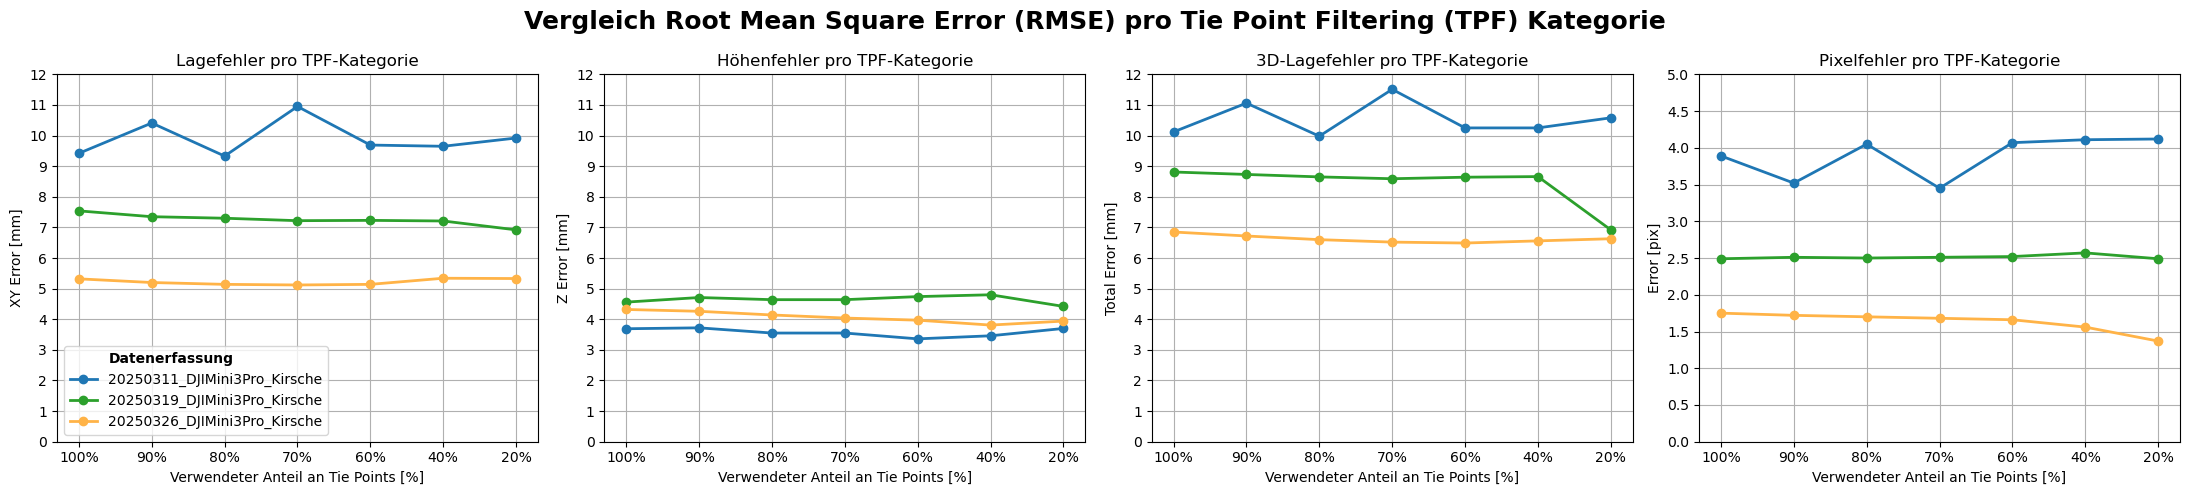

In [7]:
# TPF-Werte als Kategorien
combined_df["TPF"] = pd.Categorical(
    combined_df["TPF"],
    categories=["100%", "90%", "80%", "70%", "60%", "40%", "20%"],
    ordered=True
)

# Attributnamen + Titel + y-Achsenbeschriftung + Achsenskalierung
attributes = [
    ("XY_Error_mm", "Lagefehler pro TPF-Kategorie", "XY Error [mm]", (0, 12), 1),
    ("Z_Error_mm", "Höhenfehler pro TPF-Kategorie", "Z Error [mm]", (0, 12), 1),
    ("Total_Error_mm", "3D-Lagefehler pro TPF-Kategorie", "Total Error [mm]", (0, 12), 1),
    ("Error_pix", "Pixelfehler pro TPF-Kategorie", "Error [pix]", (0, 5), 0.5),
]

# Farbzuweisung für Aufnahme_IDs
aufnahme_colors = {
    "20250311_DJIMini3Pro_Kirsche": "#1f77b4",        # Blau
    "20250319_DJIMini3Pro_Kirsche": "#2ca02c",        # Grün
    "20250326_DJIMini3Pro_Kirsche": "#FFB347",        # Orange
}

# Subplots
fig, axes = plt.subplots(1, 4, figsize=(22, 5), sharex=True)

for ax, (attr, title, ylabel, ylim, step) in zip(axes, attributes):
    for aufnahme_id, group in combined_df.groupby("Aufnahme_ID"):
        group_sorted = group.sort_values("TPF")
        ax.plot(
            group_sorted["TPF"],
            group_sorted[attr],
            label=aufnahme_id,
            marker="o",
            linewidth=2,
            color=aufnahme_colors[aufnahme_id]
        )
    ax.set_title(title)
    ax.set_ylim(*ylim)
    ax.yaxis.set_major_locator(MultipleLocator(step))
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Verwendeter Anteil an Tie Points [%]")
    ax.grid(True)

# Titel für alle Plots
fig.suptitle(
    "Vergleich Root Mean Square Error (RMSE) pro Tie Point Filtering (TPF) Kategorie",
    fontsize=18,
    fontweight="bold"
)

# Platzierung der Legende 
handles, labels = axes[0].get_legend_handles_labels()
handles = [plt.Line2D([], [], color='none')] + handles
labels = ["Datenerfassung"] + labels
legend = axes[0].legend(handles, labels, loc="lower left", frameon=True)

# Stil der Legende
legend.get_texts()[0].set_weight("bold")     
legend.get_texts()[0].set_fontsize("medium")

plt.tight_layout()
plt.show()

### 1.3 Vergleich Root Mean Square Error (RMSE) pro Tie Point Filtering (TPF) Kategorie - Detailansicht Total Error

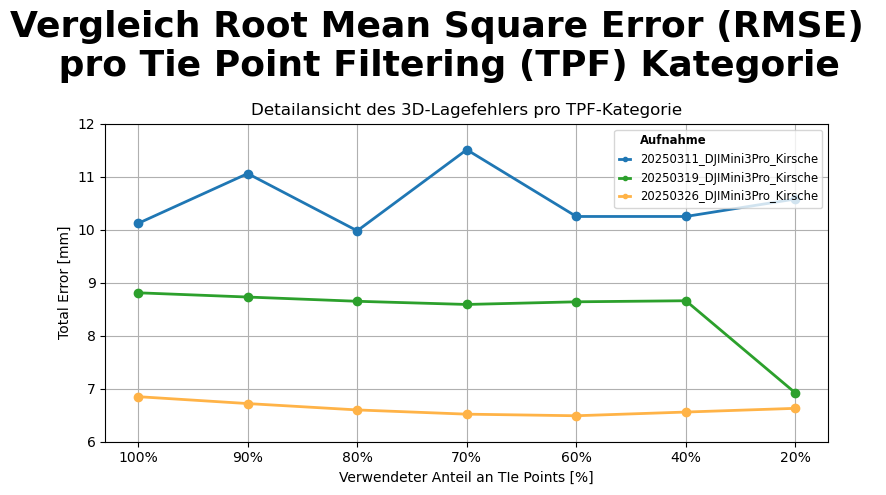

In [16]:
# DETAILPLOT für Total_Error_mm
fig, ax = plt.subplots(figsize=(8, 5))

for aufnahme_id, group in combined_df.groupby("Aufnahme_ID"):
    group_sorted = group.sort_values("TPF")
    ax.plot(
        group_sorted["TPF"],
        group_sorted["Total_Error_mm"],
        label=aufnahme_id,
        marker="o",
        linewidth=2,
        color=aufnahme_colors.get(aufnahme_id, "grey")
    )

ax.set_title("Detailansicht des 3D-Lagefehlers pro TPF-Kategorie")
ax.set_ylabel("Total Error [mm]")
ax.set_xlabel("Verwendeter Anteil an TIe Points [%]")
ax.set_ylim(6, 12)
ax.grid(True)

# Gemeinsamer Titel für alle Plots
fig.suptitle(
    "Vergleich Root Mean Square Error (RMSE) \n pro Tie Point Filtering (TPF) Kategorie",
    fontsize=26,
    fontweight="bold"
)

# Legende unten links mit Titel als Dummy-Zeile (Workaround)
handles, labels = ax.get_legend_handles_labels()
handles = [plt.Line2D([], [], color='none')] + handles
labels = ["Aufnahme"] + labels
legend = ax.legend(handles, labels, loc="upper right",fontsize = "small", frameon=True, handlelength=1.0, markerscale=0.5)
legend.get_texts()[0].set_weight("bold")
legend.get_texts()[0].set_fontsize("small")

plt.tight_layout()
plt.show()

### 1.4 Vergleich Root Mean Square Error (RMSE) pro Tie Point Filtering (TPF) Kategorie -> für Dokumentation

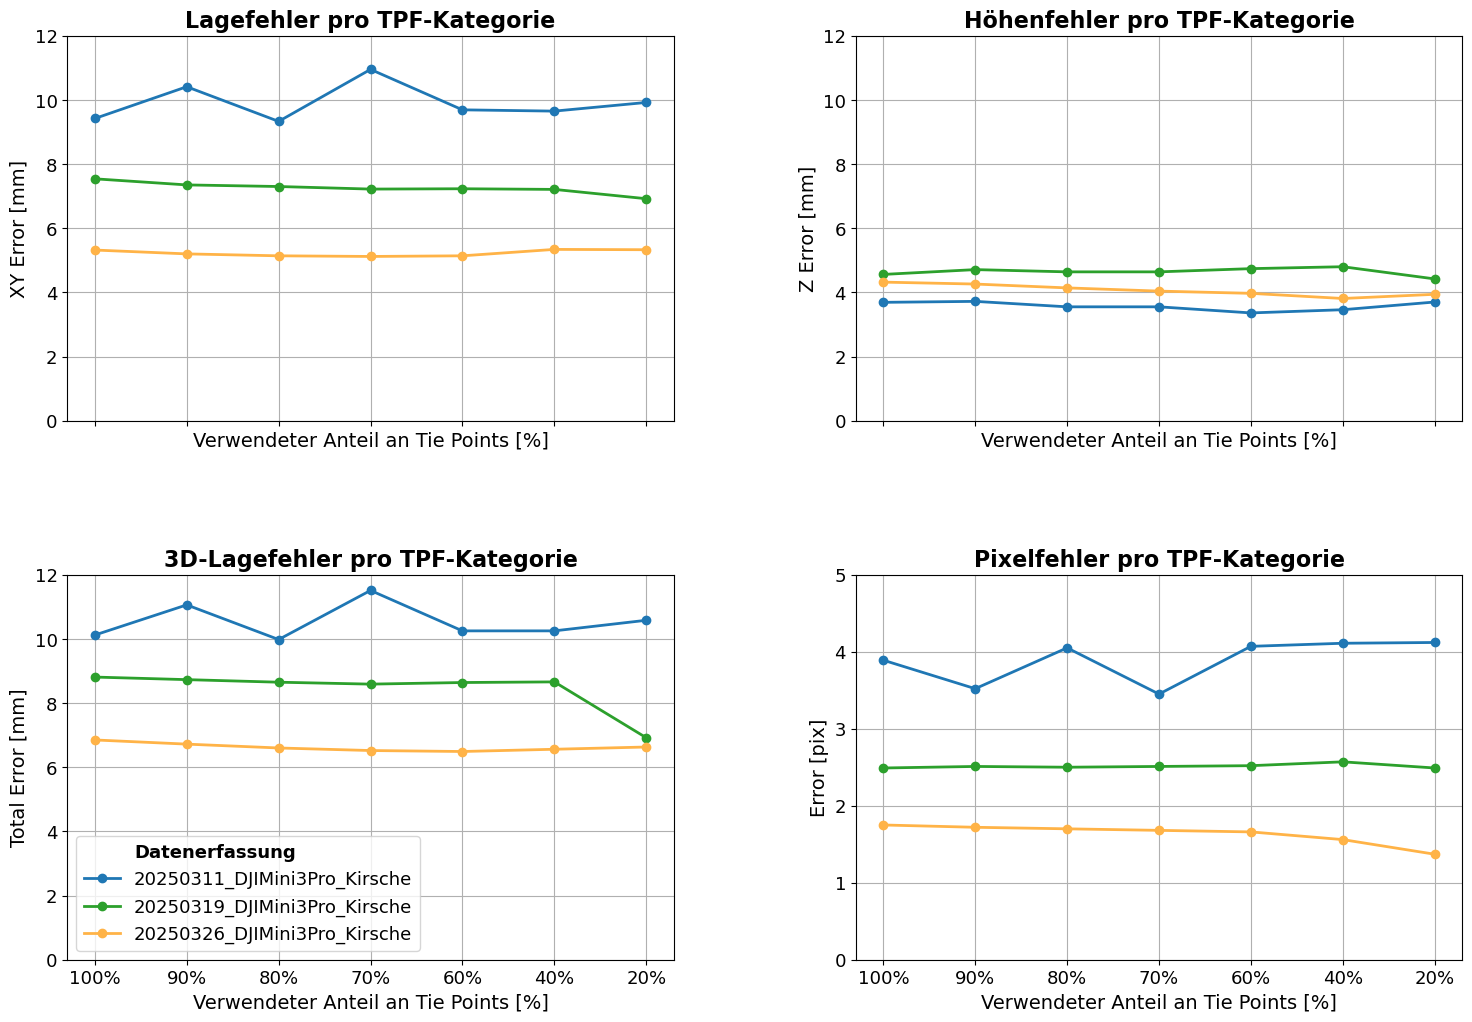

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd

# TPF-Kategorien festlegen
combined_df["TPF"] = pd.Categorical(
    combined_df["TPF"],
    categories=["100%", "90%", "80%", "70%", "60%", "40%", "20%"],
    ordered=True
)

# Attributdefinitionen
attributes = [
    ("XY_Error_mm", "Lagefehler pro TPF-Kategorie", "XY Error [mm]", (0, 12), 1),
    ("Z_Error_mm", "Höhenfehler pro TPF-Kategorie", "Z Error [mm]", (0, 12), 1),
    ("Total_Error_mm", "3D-Lagefehler pro TPF-Kategorie", "Total Error [mm]", (0, 12), 1),
    ("Error_pix", "Pixelfehler pro TPF-Kategorie", "Error [pix]", (0, 5), 0.5),
]

# Farbdefinition pro Aufnahme
aufnahme_colors = {
    "20250311_DJIMini3Pro_Kirsche": "#1f77b4",
    "20250319_DJIMini3Pro_Kirsche": "#2ca02c",
    "20250326_DJIMini3Pro_Kirsche": "#FFB347",
}

# X-Achsen-Ticks fix
x_categories = ["100%", "90%", "80%", "70%", "60%", "40%", "20%"]

# Plot-Vorbereitung
fig, axes = plt.subplots(2, 2, figsize=(18, 12), sharex=True)
axes = axes.flatten()

for ax, (attr, title, ylabel, ylim, step) in zip(axes, attributes):
    for aufnahme_id, group in combined_df.groupby("Aufnahme_ID"):
        group_sorted = group.sort_values("TPF")
        ax.plot(
            group_sorted["TPF"],
            group_sorted[attr],
            label=aufnahme_id,
            marker="o",
            linewidth=2,
            color=aufnahme_colors[aufnahme_id]
        )
    ax.set_title(title, fontweight="bold", fontsize=16)
    ax.set_ylim(*ylim)
    ax.set_xticks(x_categories)
    ax.set_xticklabels(x_categories, rotation=0, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel("Verwendeter Anteil an Tie Points [%]", fontsize=14)
    ax.tick_params(axis='y', labelsize=13)
    ax.grid(True)

# Legende unten links im untersten linken Plot (Index 2)
handles, labels = axes[2].get_legend_handles_labels()
handles = [plt.Line2D([], [], color='none')] + handles
labels = ["Datenerfassung"] + labels
legend = axes[2].legend(
    handles, labels,
    loc="lower left",
    frameon=True,
    fontsize=13
)
legend.get_texts()[0].set_weight("bold")

# Abstand zwischen den Plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

